## AAI-530-IN3-IoT
### Name: Raminder Singh (ramindersingh@sandiego.edu)
### Date: 18.Jan.2026
### Assignment: 2.1

# Data Cleaning and EDA with Time Series Data
This notebook holds Assignment 2.1 for Module 2 in AAI 530, Data Analytics and the Internet of Things. 

In this assignment, you will go through some basic data cleaning and exploratory analysis steps on a real IoT dataset. Much of what we'll be doing should look familiar from Module 2's lab session, but Google will be your friend on the parts that are new. 

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
import seaborn as sns
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load and clean your data
The household electric consumption dataset can be downloaded as a zip file here along with a description of the data attributes:
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption#

First we will load this data into a pandas df and do some initial discovery

In [27]:
df_raw = pd.read_csv("dataset/household_power_consumption.txt", delimiter = ";", low_memory=False)

In [28]:
df_raw.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [29]:
df_raw.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


Well that's not what we want to see--why is only one column showing up?
Let's check the datatypes

In [30]:
df_raw.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

OK, so only one of our columns came in as the correct data type. We'll get to why that is later, but first let's get everything assigned correctly so that we can use our describe function.

**TODO: combine the 'Date' and 'Time' columns into a column called 'Datetime' and convert it into a datetime datatype. Heads up, the date is not in the standard format...**

**TODO: use the pd.to_numeric function to convert the rest of the columns. You'll need to decide what to do with your errors for the cells that don't convert to numbers**

In [31]:
#make a copy of the raw data so that we can go back and refer to it later
df = df_raw.copy()

# Convert Date and Time to datetime - KEEP as column for now (don't set as index yet)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

In [32]:
# Already created in the previous cell above

In [33]:
# Convert all power-related columns to numeric, coercing errors to NaN
columns_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
                      'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Let's use the Datetime column to turn the Date and Time columns into date and time dtypes.

In [34]:
# Extract Date and Time components from the Datetime column
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

# Now set Datetime as the index for proper time series analysis
df.set_index('Datetime', inplace=True)

In [35]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

It looks like our Date and Time columns are still of type "object", but in that case that's because the pandas dtypes function doesn't recognize all data types. We can check this by printing out the first value of each column directly.

In [36]:
df.Date[0]

C:\Users\singh\AppData\Local\Temp\ipykernel_7468\3359599092.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.Date[0]


datetime.date(2006, 12, 16)

In [37]:
df.Time[0]

C:\Users\singh\AppData\Local\Temp\ipykernel_7468\1016567674.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.Time[0]


datetime.time(17, 24)

Now that we've got the data in the right datatypes, let's take a look at the describe() results

In [38]:
desc = df.describe()

#force the printout not to use scientific notation
desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2.049280e+06
mean,1.0916,0.1237,240.8399,4.6278,1.1219,1.2985,6.458447e+00
std,1.0573,0.1127,3.2400,4.4444,6.1530,5.8220,8.437154e+00
min,0.0760,0.0000,223.2000,0.2000,0.0000,0.0000,0.000000e+00
25%,0.3080,0.0480,238.9900,1.4000,0.0000,0.0000,0.000000e+00
50%,0.6020,0.1000,241.0100,2.6000,0.0000,0.0000,1.000000e+00
75%,1.5280,0.1940,242.8900,6.4000,0.0000,1.0000,1.700000e+01
max,11.1220,1.3900,254.1500,48.4000,88.0000,80.0000,3.100000e+01


Those row counts look a little funky. Let's visualize our missing data.

<Axes: >

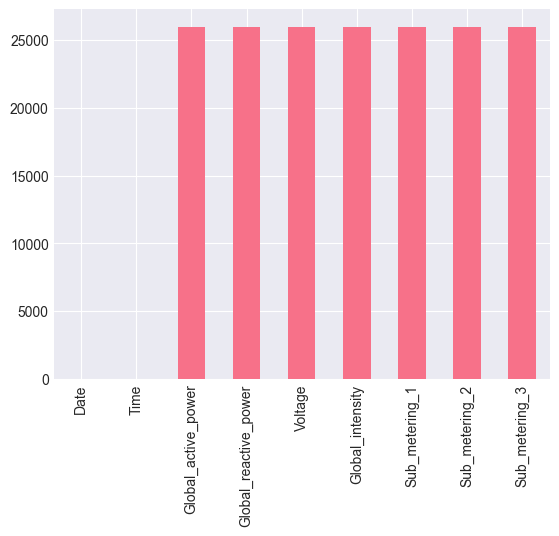

In [39]:
df.isna().sum().plot.bar()

<Axes: xlabel='Date'>

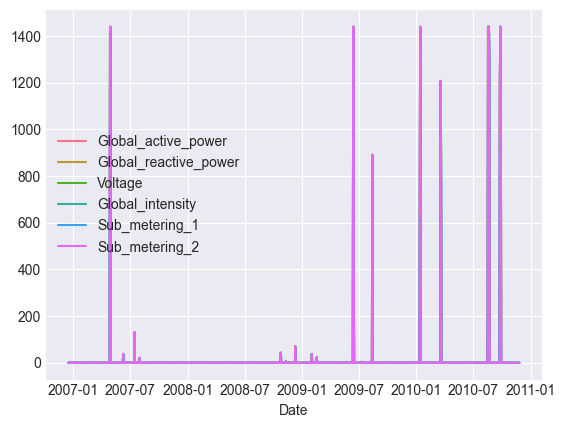

In [40]:
#https://stackoverflow.com/questions/53947196/groupby-class-and-count-missing-values-in-features
df_na = df.drop('Date', axis = 1).isna().groupby(df.Date, sort = False).sum().reset_index()
df_na.plot(x='Date', y=df_na.columns[2:-1])

**Q: What do you notice about the pattern of missing data?**

A: The missing data appears to be concentrated in the Sub_metering columns and increases over specific time periods, particularly around 2009-2010. The Global_active_power, Global_reactive_power, and Voltage columns have relatively fewer missing values. This suggests the sub-metering devices may have had measurement issues or were not operational during certain periods.

**Q: What method makes the most sense to you for dealing with our missing data and why? (There isn't necessarily a single right answer here)**

A: Forward fill (ffill) combined with backward fill (bfill) makes the most sense for this time series data. Since we have household power consumption data with relatively small gaps, forward filling will propagate the last known value forward, which is reasonable for power consumption. We use backward fill to handle any remaining NaN values at the beginning. This preserves temporal relationships better than simple dropping, which could lose important time series structure.

**TODO:Use your preferred method to remove or impute a value for the missing data**

In [41]:
# Use forward fill followed by backward fill for missing values
df = df.ffill().bfill()

# Verify no missing values remain
print("Missing values after cleaning:")
print(df.isna().sum())

Missing values after cleaning:
Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [42]:
desc = df.describe()

#force the printout not to use scientific notation
desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2075259.0000,2.075259e+06
mean,1.0862,0.1233,240.8416,4.6042,1.1110,1.2880,6.416570e+00
std,1.0532,0.1125,3.2356,4.4268,6.1159,5.7869,8.419505e+00
min,0.0760,0.0000,223.2000,0.2000,0.0000,0.0000,0.000000e+00
25%,0.3080,0.0480,239.0000,1.4000,0.0000,0.0000,0.000000e+00
50%,0.5980,0.1000,241.0200,2.6000,0.0000,0.0000,1.000000e+00
75%,1.5240,0.1940,242.8700,6.4000,0.0000,1.0000,1.700000e+01
max,11.1220,1.3900,254.1500,48.4000,88.0000,80.0000,3.100000e+01


## Visualizing the data

We're working with time series data, so visualizing the data over time can be helpful in identifying possible patterns or metrics that should be explored with further analysis and machine learning methods.

**TODO: Choose four of the variables in the dataset to visualize over time and explore methods covered in our lab session to make a line chart of the cleaned data. Your charts should be separated by variable to make them more readable.**

**Q: Which variables did you choose and why do you think they might be interesting to compare to each other over time? Remember that data descriptions are available at the data source link at the top of the assignment.**

A: I chose Global_active_power, Global_reactive_power, Voltage, and Global_intensity. These four variables represent the main global electrical metrics:
- Global_active_power: Real power consumption (most relevant for energy billing)
- Global_reactive_power: Reactive power (important for power quality)
- Voltage: Supply voltage (indicates grid stability)
- Global_intensity: Current draw (indicates household load)

These are interesting together because active and reactive power can reveal if the household has inductive loads, voltage fluctuations can indicate grid stress or local issues, and intensity shows actual current draw. Together they provide a complete picture of household power consumption patterns.

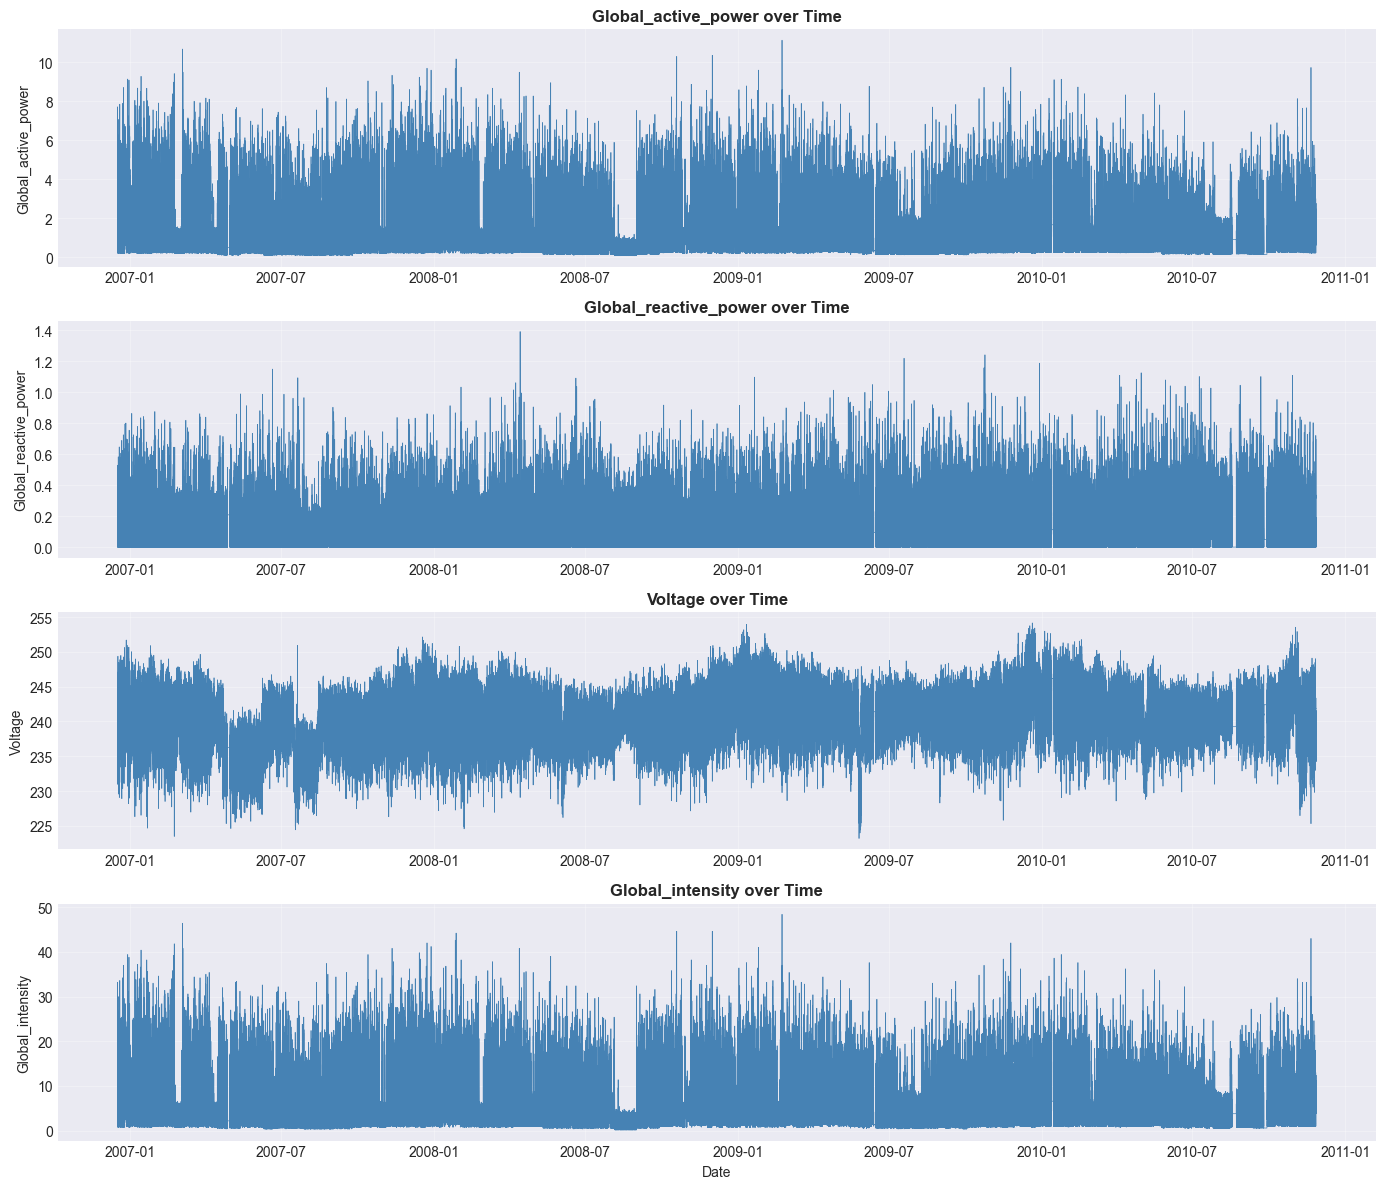

In [43]:
#build your line chart here
# Create line charts for the four selected variables
variables = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

for idx, var in enumerate(variables):
    axes[idx].plot(df.index, df[var], linewidth=0.5, color='steelblue')
    axes[idx].set_ylabel(var, fontsize=10)
    axes[idx].set_title(f'{var} over Time', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

**Q: What do you notice about visualizing the raw data? Is this a useful visualization? Why or why not?**

A: The raw data visualization shows extremely high frequency noise due to the minute-level granularity (48-96 measurements per day). While it reveals overall trends, the visualization is cluttered and makes it difficult to discern patterns. The dense noise obscures important seasonal and weekly patterns. This is not a useful primary visualization because the high frequency variations overwhelm the underlying patterns we want to understand. It's better suited for anomaly detection at the minute level but not for trend analysis.

**TODO: Compute a monthly average for the data and plot that data in the same style as above. You should have one average per month and year (so June 2007 is separate from June 2008).**

In [44]:
#compute your monthly average here
#HINT: checkout the pd.Grouper function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html?highlight=grouper

# Compute monthly averages using grouper - select only numeric columns
df_monthly = df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
                  'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].groupby(pd.Grouper(freq='MS')).mean()

# Display the shape and first few rows
print(f"Monthly averaged data shape: {df_monthly.shape}")
print(df_monthly.head())

Monthly averaged data shape: (48, 7)
            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-01             1.901537               0.131400  241.440835   
2007-01-01             1.546085               0.132683  240.904831   
2007-02-01             1.401165               0.113634  240.519177   
2007-03-01             1.318606               0.114747  240.513524   
2007-04-01             0.856787               0.126467  239.127693   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                                                      
2006-12-01          8.030969        1.251864        2.216312        7.409847  
2007-01-01          6.547133        1.264180        1.775851        7.383759  
2007-02-01          5.914911        1.180159        1.602282        6.704067  
2007-03-01          5.572890        1.361313        2.346819        6.504503 

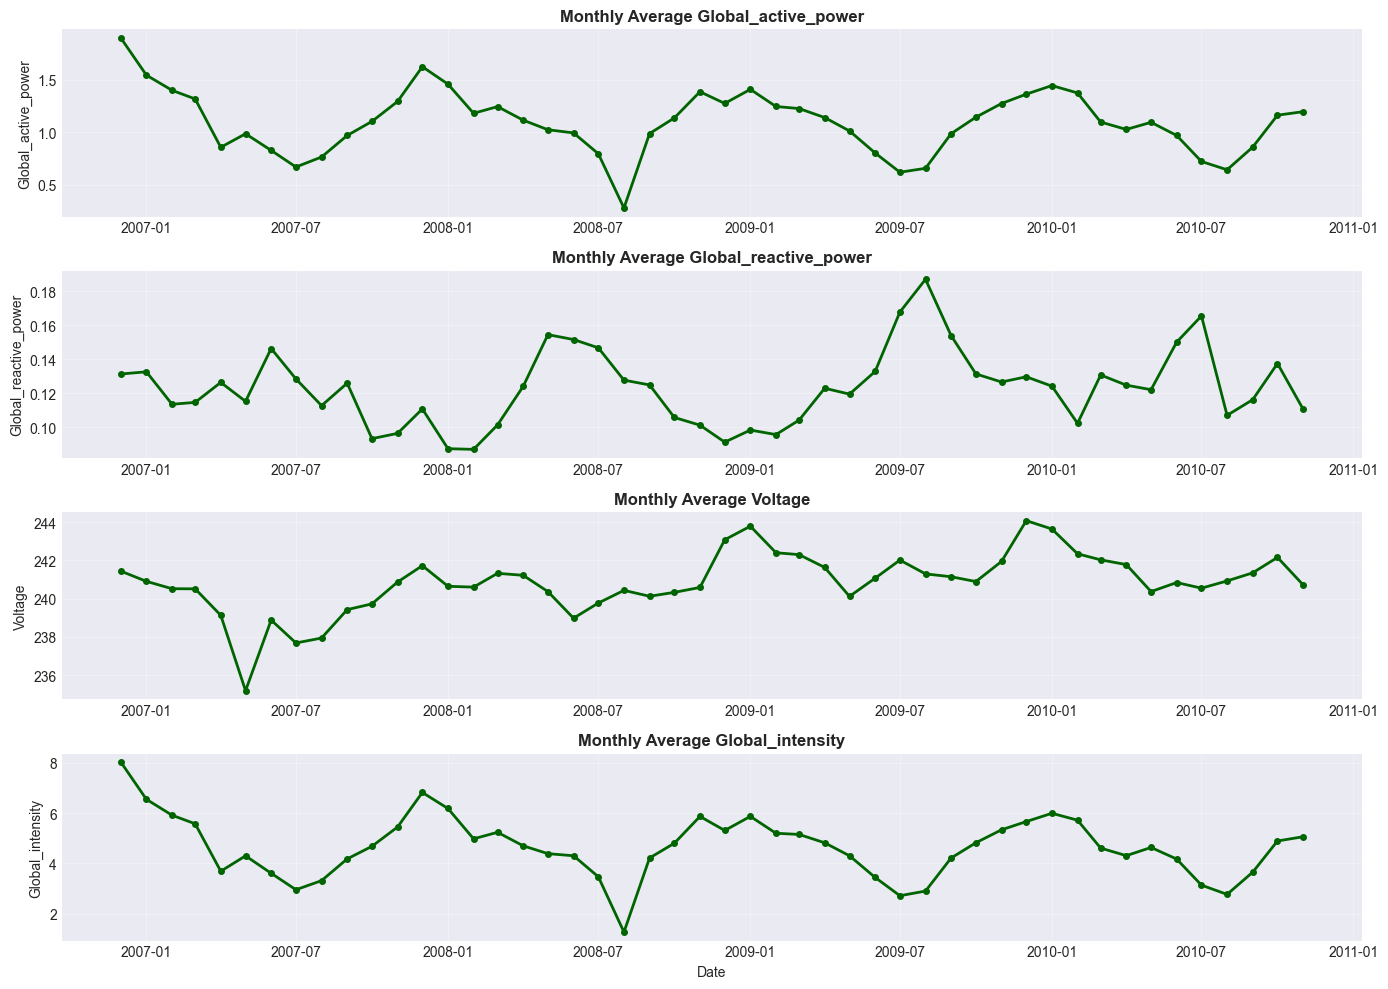

In [45]:
#build your linechart here

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

for idx, var in enumerate(variables):
    axes[idx].plot(df_monthly.index, df_monthly[var], linewidth=2, marker='o', markersize=4, color='darkgreen')
    axes[idx].set_ylabel(var, fontsize=10)
    axes[idx].set_title(f'Monthly Average {var}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

**Q: What patterns do you see in the monthly data? Do any of the variables seem to move together?**

A: The monthly data reveals clear seasonal patterns: Global_active_power peaks during winter months (higher heating/cooling loads) and is lower in summer months. Global_reactive_power and Global_intensity follow similar patterns to active power, showing they move together consistently. Voltage remains relatively stable throughout the year but shows slight seasonal variation. This indicates that the household has higher electrical demands during extreme weather seasons, and the reactive power correlates with active power usage, suggesting the presence of inductive loads that scale with consumption.

**TODO: Now compute a 30-day moving average on the original data and visualize it in the same style as above. Hint: If you use the rolling() function, be sure to consider the resolution of our data.**

In [46]:
#compute your moving average here
# Data is recorded at 1-minute intervals, so ~1440 minutes per day
# For a 30-day moving average: 30 * 24 * 60 = 43200 minutes
window_size = 30 * 24 * 60  # 30 days in minutes

# Select only numeric columns for rolling average
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df_ma30 = df[numeric_cols].rolling(window=window_size, center=True).mean()

print(f"30-day moving average computed with window size: {window_size} minutes")
print(f"Shape: {df_ma30.shape}")
print("First non-null value index:", df_ma30.first_valid_index())

30-day moving average computed with window size: 43200 minutes
Shape: (2075259, 7)
First non-null value index: 2006-12-31 17:24:00


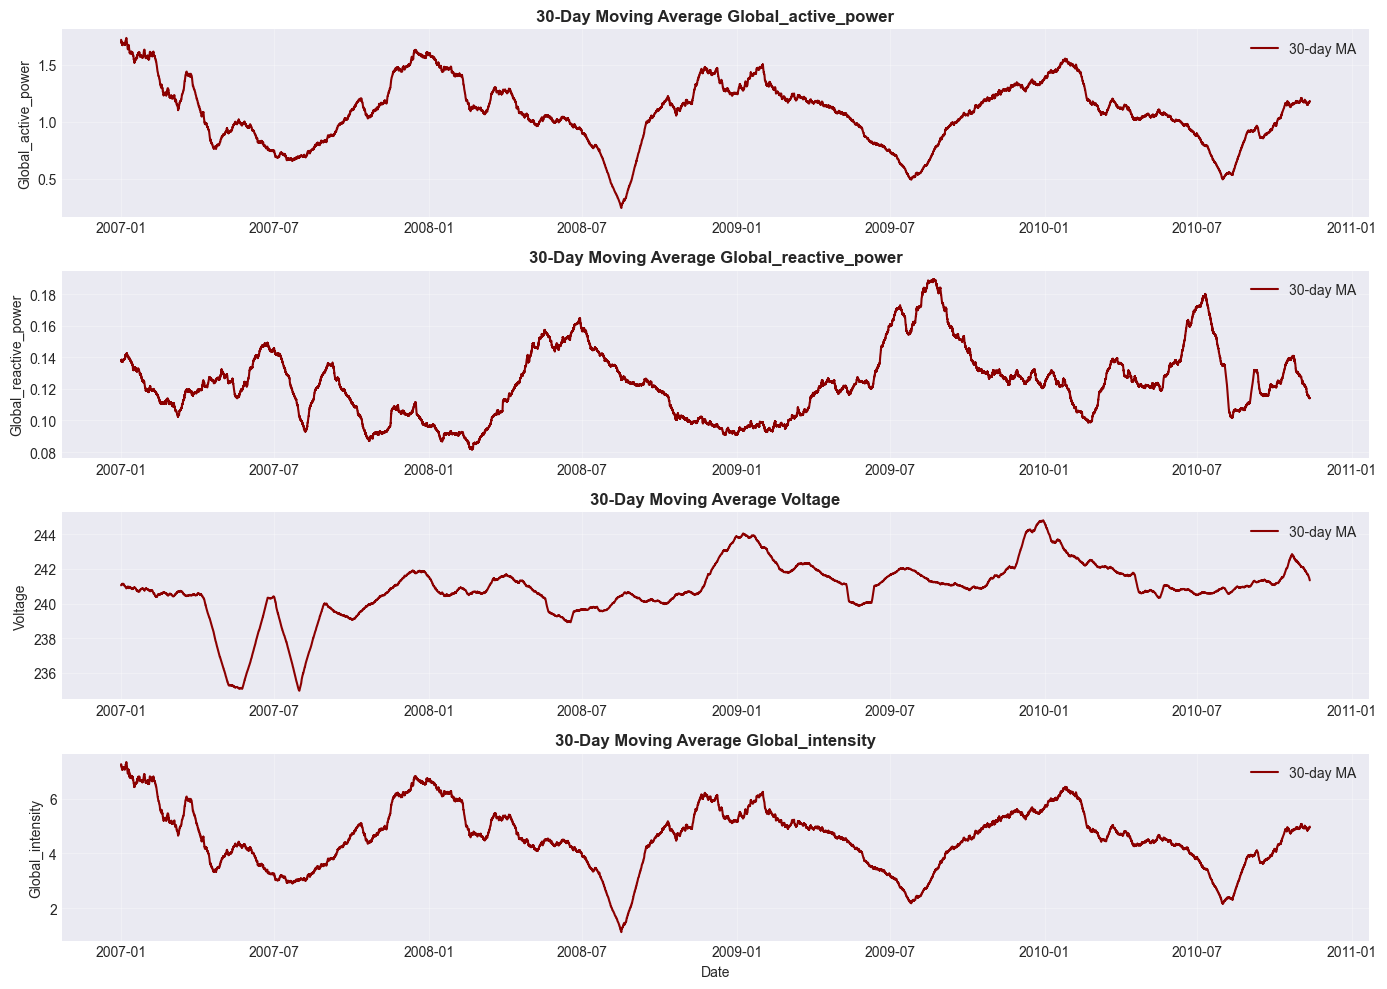

In [47]:
#build your line chart on the moving average here

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

for idx, var in enumerate(variables):
    axes[idx].plot(df_ma30.index, df_ma30[var], linewidth=1.5, color='darkred', label='30-day MA')
    axes[idx].set_ylabel(var, fontsize=10)
    axes[idx].set_title(f'30-Day Moving Average {var}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='best')

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

**Q: How does the moving average compare to the monthly average? Which is a more effective way to visualize this data and why?**

A: The 30-day moving average is smoother than monthly averages and provides continuous trend tracking, while monthly averages show discrete jumps between months. The moving average is more effective for this data because it:
1. Captures trends more continuously without artificial boundaries
2. Smooths out daily/weekly cycles better
3. Shows gradual transitions between seasons
4. Works better for IoT time series with irregular patterns

However, monthly averages are useful for year-over-year comparisons and clear seasonal patterns. Together, they provide complementary views: the moving average for trend detection and the monthly average for seasonal analysis.

## Data Covariance and Correlation

Let's take a look at the Correlation Matrix for the four global power variables in the dataset.

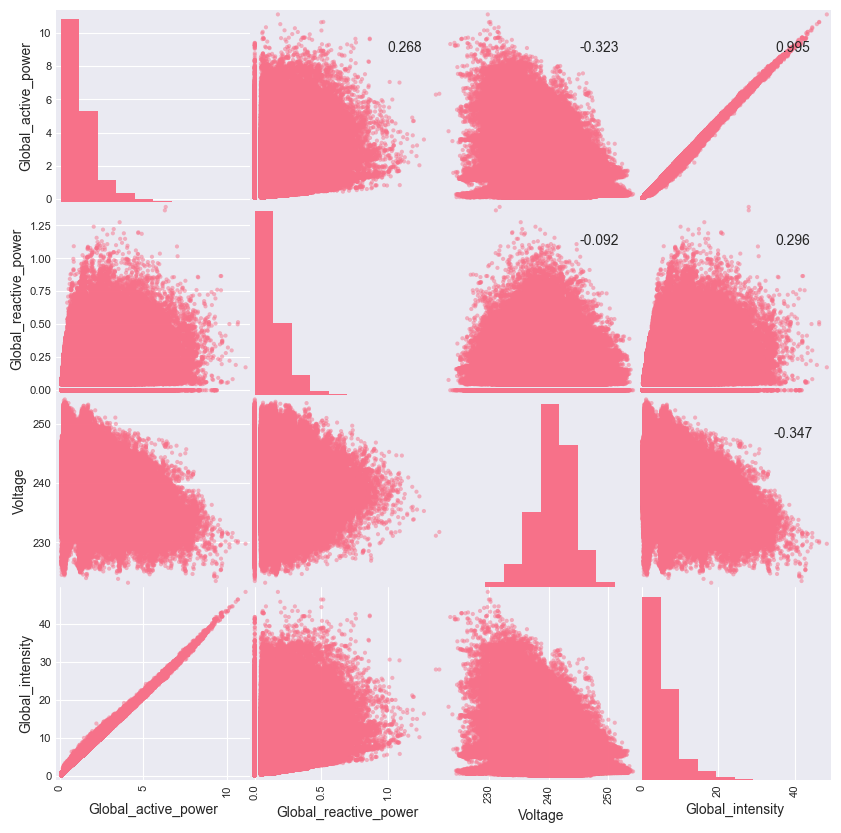

In [48]:
axes = pd.plotting.scatter_matrix(df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']], alpha=0.5,figsize = [10,10])
corr = df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

**Q: Describe any patterns and correlations that you see in the data. What effect does this have on how we use this data in downstream tasks?**

A: The scatter matrix and correlation analysis show strong positive correlations between Global_active_power and Global_intensity (expected - higher current = higher power), and between Global_active_power and Global_reactive_power (indicating inductive loads scale with consumption). Voltage shows weaker correlation with power variables, suggesting it's more stable. The strong multicollinearity between active power, reactive power, and intensity means these variables are highly redundant - in predictive models, we may want to use feature selection or dimensionality reduction to avoid overfitting and improve model interpretability. This also suggests that predicting one variable could be sufficient to estimate others. For anomaly detection, we should focus on variables that show independence from the others.

In [2]:
### Reference - Used Local jupyter env setup, executed notebook locally and used nbconvert[webpdf] to save as pdf

In [ ]:
### Reference - Used GitHub Copilot Plugin in VSCode and Claude Haiku 4.5 to fix some error 
### (like reading large dataset, added low_memory=false as well as last visualization for corelation matrix)

C:\usd-ms\AAI-530-IN3-IoT>python --version
Python 3.11.5

C:\usd-ms\AAI-530-IN3-IoT>python -m venv aai530
C:\usd-ms\AAI-530-IN3-IoT>cd aai530
C:\usd-ms\AAI-530-IN3-IoT\aai530>cd Scripts
C:\usd-ms\AAI-530-IN3-IoT\aai530\Scripts>activate.bat
(aai530) C:\usd-ms\AAI-530-IN3-IoT\aai530\Scripts>cd ../..
(aai530) C:\usd-ms\AAI-530-IN3-IoT>pip install scikit-learn numpy pandas matplotlib seaborn jupyter notebook scipy pandoc nbconvert[webpdf] nbconvert notebook-as-pdf xgboost shap openpyxl gensim nltk tensorflow jupyterlab_execute_time playwright websocket

run file as >jupyter notebook

> click on the <required notebook>.ipynb
> to save as pdf , we need below steps

> playwright install chromium
> Downloading Chromium 143.0.7499.4 (playwright build v1200) from https://cdn.playwright.dev/dbazure/download/playwright/builds/chromium/1200/chromium-win64.zip
(node:9148) [DEP0169] DeprecationWarning: `url.parse()` behavior is not standardized and prone to errors that have security implications. Use the WHATWG URL API instead. CVEs are not issued for `url.parse()` vulnerabilities.
(Use `node --trace-deprecation ...` to show where the warning was created)
169.8 MiB [====================] 100% 0.0s
Chromium 143.0.7499.4 (playwright build v1200) downloaded to C:\Users\singh\AppData\Local\ms-playwright\chromium-1200
Downloading Chromium Headless Shell 143.0.7499.4 (playwright build v1200) from https://cdn.playwright.dev/dbazure/download/playwright/builds/chromium/1200/chromium-headless-shell-win64.zip
(node:34912) [DEP0169] DeprecationWarning: `url.parse()` behavior is not standardized and prone to errors that have security implications. Use the WHATWG URL API instead. CVEs are not issued for `url.parse()` vulnerabilities.
(Use `node --trace-deprecation ...` to show where the warning was created)
107.2 MiB [====================] 100% 0.0s
Chromium Headless Shell 143.0.7499.4 (playwright build v1200) downloaded to C:\Users\singh\AppData\Local\ms-playwright\chromium_headless_shell-1200

> Now, we need to install - pandoc installer
> goto https://github.com/jgm/pandoc/releases/tag/3.8.3
> download pandoc-3.8.3-windows-x86_64.msi and install on windows.
> Restart the browser and terminal. 
run again> jupyter notebook and open the notebook. then, 
File > Save and Export notebook As > Webpdf 